## Change logs
This version v2 is to adapt to the source file change to https://github.com/CSSEGISandData/COVID-19

In [2]:
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

pio.templates.default = "plotly_white"

import json
import topojson

## Worldwide cases

In [42]:
covid_data_confirmed = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
covid_data_fatalities = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
covid_data_recovered = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [44]:
covid_data_confirmed = covid_data_confirmed[covid_data_confirmed.columns[~covid_data_confirmed.columns.isin(['Lat', 'Long'])]].groupby('Country/Region').sum().reset_index()
covid_data_fatalities = covid_data_fatalities[covid_data_fatalities.columns[~covid_data_fatalities.columns.isin(['Lat', 'Long'])]].groupby('Country/Region').sum().reset_index()
covid_data_recovered = covid_data_recovered[covid_data_recovered.columns[~covid_data_recovered.columns.isin(['Lat', 'Long'])]].groupby('Country/Region').sum().reset_index()

In [45]:
covid_data_confirmed = covid_data_confirmed.melt(id_vars='Country/Region', var_name='date', value_name='confirmed')
covid_data_fatalities = covid_data_fatalities.melt(id_vars='Country/Region', var_name='date', value_name='fatalities')
covid_data_recovered = covid_data_recovered.melt(id_vars='Country/Region', var_name='date', value_name='recovered')

In [47]:
covid_data_confirmed['date'] = pd.to_datetime(covid_data_confirmed['date'])
covid_data_fatalities['date'] = pd.to_datetime(covid_data_fatalities['date'])
covid_data_recovered['date'] = pd.to_datetime(covid_data_recovered['date'])

In [55]:
global_confirmed = covid_data_confirmed.groupby('date').confirmed.sum()
global_fatalities = covid_data_fatalities.groupby('date').fatalities.sum()
global_recovered = covid_data_recovered.groupby('date').recovered.sum()
global_covid_data = pd.concat([global_confirmed, global_fatalities, global_recovered], axis=1)

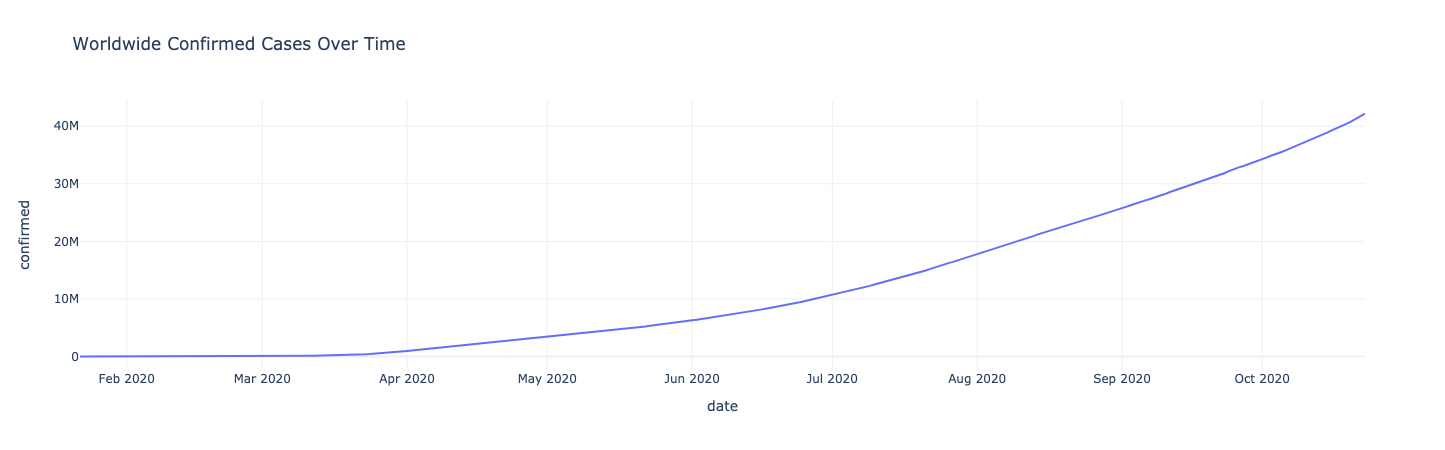

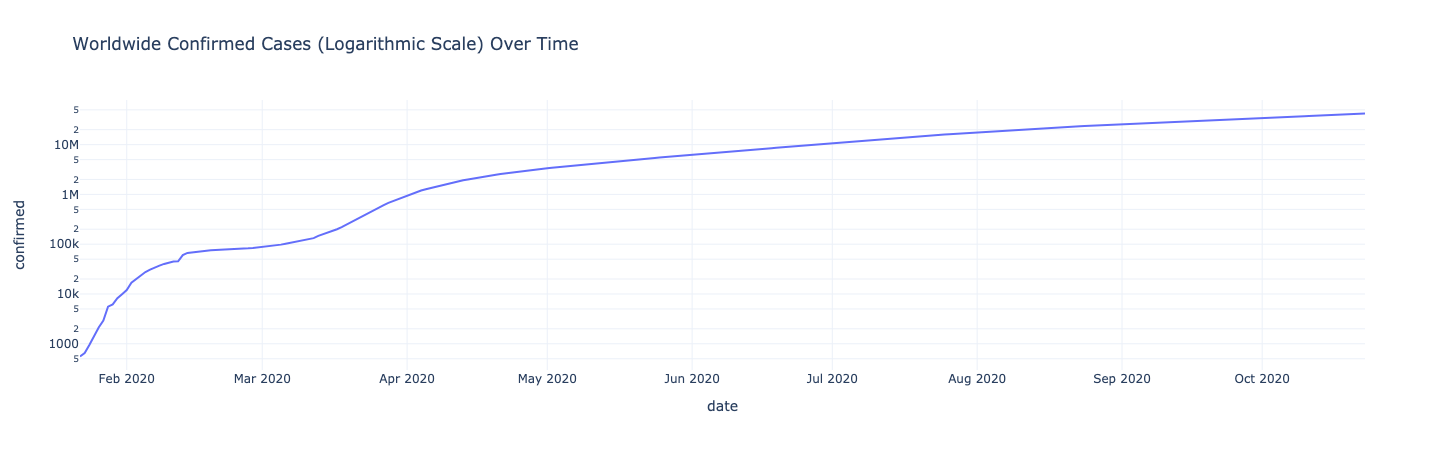

In [58]:
fig = px.line(global_covid_data, x=global_covid_data.index, y="confirmed", 
              title="Worldwide Confirmed Cases Over Time")
fig.show()

fig = px.line(global_covid_data, x=global_covid_data.index, y="confirmed", 
              title="Worldwide Confirmed Cases (Logarithmic Scale) Over Time", 
              log_y=True)
fig.show()

In [59]:
global_covid_data.to_csv('covid_world.csv')

In [72]:
def get_affected_countries(filename, value_name, top_n=10):
    latest_data = pd.read_csv(filename)
    latest_data.drop(columns=['Lat', 'Long', 'Province/State'], inplace=True)
    country_data = latest_data.groupby('Country/Region').sum().reset_index()

    colnames = sorted(
        set([match[0] for match in country_data.columns.str.findall(
            r'.*/.*/.*').values if match != []])
    )
    region_date = pd.melt(country_data, id_vars='Country/Region', value_vars=colnames, var_name='Date', value_name=value_name)

    top_10 = region_date[region_date['Date']==max(region_date['Date'])].nlargest(top_n, value_name)['Country/Region'].tolist()
    affected = region_date[region_date['Country/Region'].isin(top_10) & (region_date[value_name]>=100)]
    affected['Date']=pd.to_datetime(affected.Date, format='%m/%d/%y')
    
    return affected.sort_values(by='Date')

### Confirmed cases

In [73]:
confirmed = get_affected_countries('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 'ConfirmedCases')
confirmed.to_csv('covid_top10_confirm.csv')

<ipython-input-72-f6046a1dd64f>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



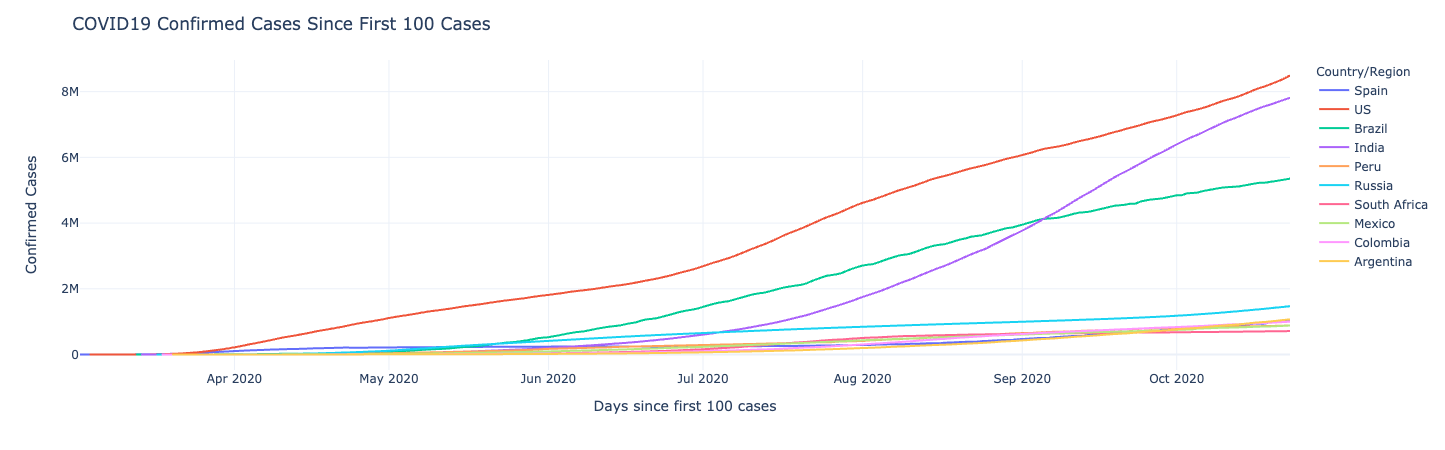

In [74]:
fig = px.line(confirmed, x='Date', y='ConfirmedCases', color='Country/Region')
fig.update_layout(title='COVID19 Confirmed Cases Since First 100 Cases',
                  xaxis_title='Days since first 100 cases',
                  yaxis_title='Confirmed Cases'
                 )
fig.show()

### Fatalities

In [75]:
fatalities= get_affected_countries('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', 'Fatalities')
fatalities.to_csv('covid_top10_fatalities.csv')

<ipython-input-72-f6046a1dd64f>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



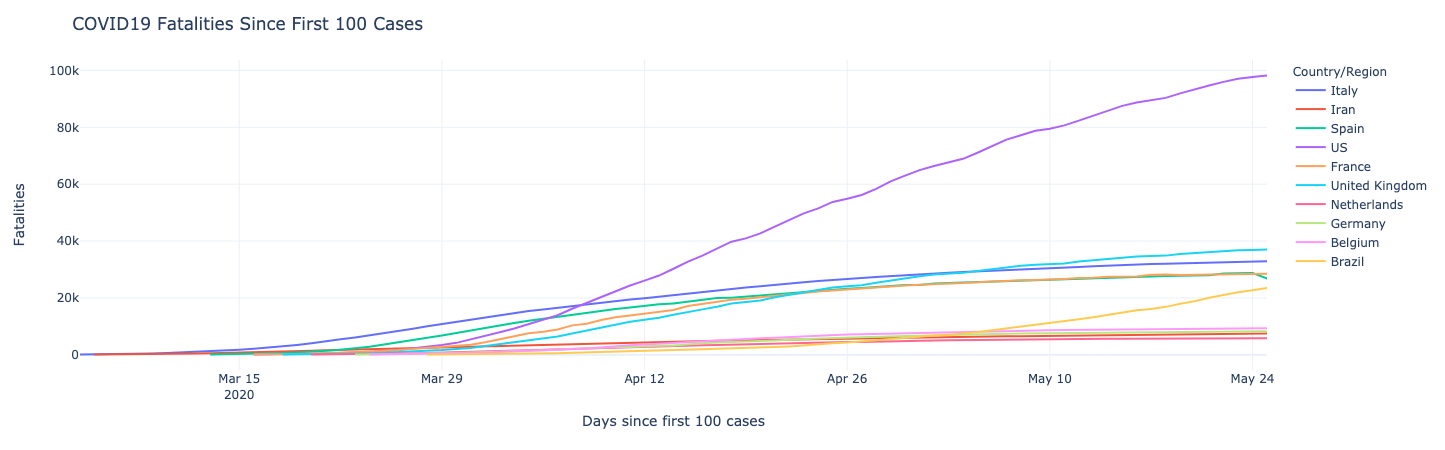

In [68]:
fig = px.line(fatalities, x='Date', y='Fatalities', color='Country/Region')

fig.update_layout(title='COVID19 Fatalities Since First 100 Cases',
                  xaxis_title='Days since first 100 cases',
                  yaxis_title='Fatalities'
                 )
fig.show()

## Europe

In [76]:
def get_affected_countries_EU(filename, value_name, top_n=15):
    latest_data = pd.read_csv(filename)
    latest_data.drop(columns=['Lat', 'Long', 'Province/State'], inplace=True)
    country_data = latest_data.groupby('Country/Region').sum().reset_index()

    colnames = sorted(
        set([match[0] for match in country_data.columns.str.findall(
            r'.*/.*/.*').values if match != []])
    )
    region_date = pd.melt(country_data, id_vars='Country/Region', value_vars=colnames, var_name='Date', value_name=value_name)
    europe = list(['Austria','Belgium','Bulgaria','Croatia','Cyprus','Czech Republic','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland',
                   'Italy', 'Latvia','Luxembourg','Lithuania','Malta','Norway','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia',
                   'Spain', 'Sweden', 'United Kingdom', 'Iceland', 'Russia', 'Switzerland', 'Serbia', 'Ukraine', 'Belarus'])
    
    region_date_eu = region_date[region_date['Country/Region'].isin(europe)]
    top_15 = region_date_eu[region_date_eu['Date']==max(region_date['Date'])].nlargest(top_n, value_name)['Country/Region'].tolist()
    affected_country = region_date_eu[region_date_eu['Country/Region'].isin(top_15) & (region_date_eu[value_name]>=100)]
    affected_country.Date=pd.to_datetime(affected_country.Date, format='%m/%d/%y')
    return affected_country.sort_values(by='Date')

In [77]:
confirmed_eu = get_affected_countries_EU('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 'ConfirmedCases')
confirmed_eu.to_csv('covid_eu_confirmed.csv')

/Users/mg/anaconda3/envs/datasays/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



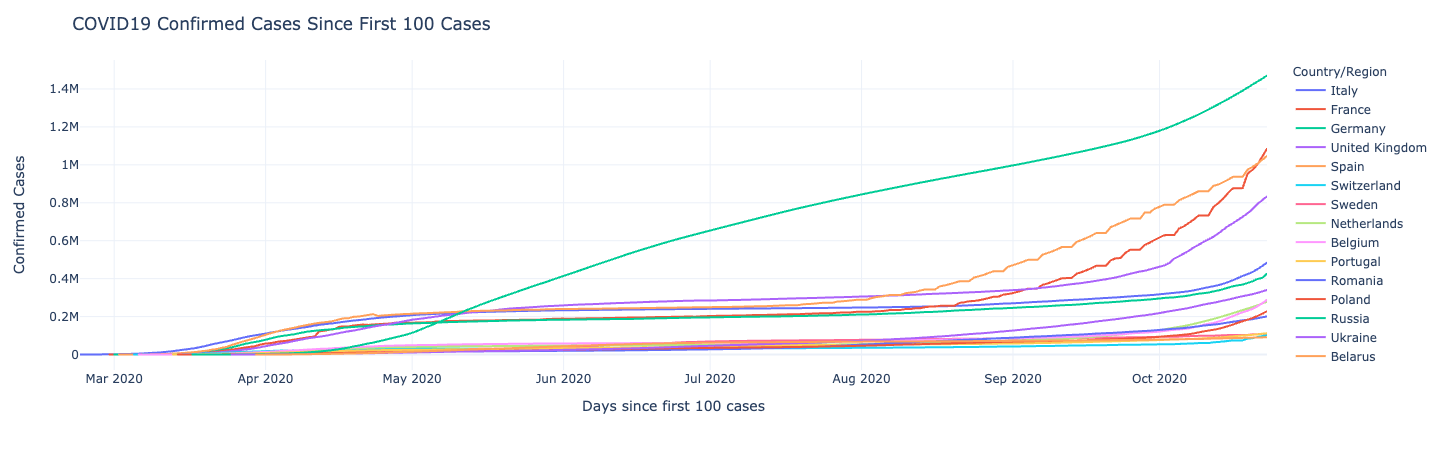

In [78]:
fig = px.line(confirmed_eu, x='Date', y='ConfirmedCases', color='Country/Region')

fig.update_layout(title='COVID19 Confirmed Cases Since First 100 Cases',
                  xaxis_title='Days since first 100 cases',
                  yaxis_title='Confirmed Cases'
                 )
fig.show()

In [79]:
fatalities_eu = get_affected_countries_EU('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', 'Fatalities')
fatalities_eu.to_csv('covid_eu_fatalities.csv')

/Users/mg/anaconda3/envs/datasays/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



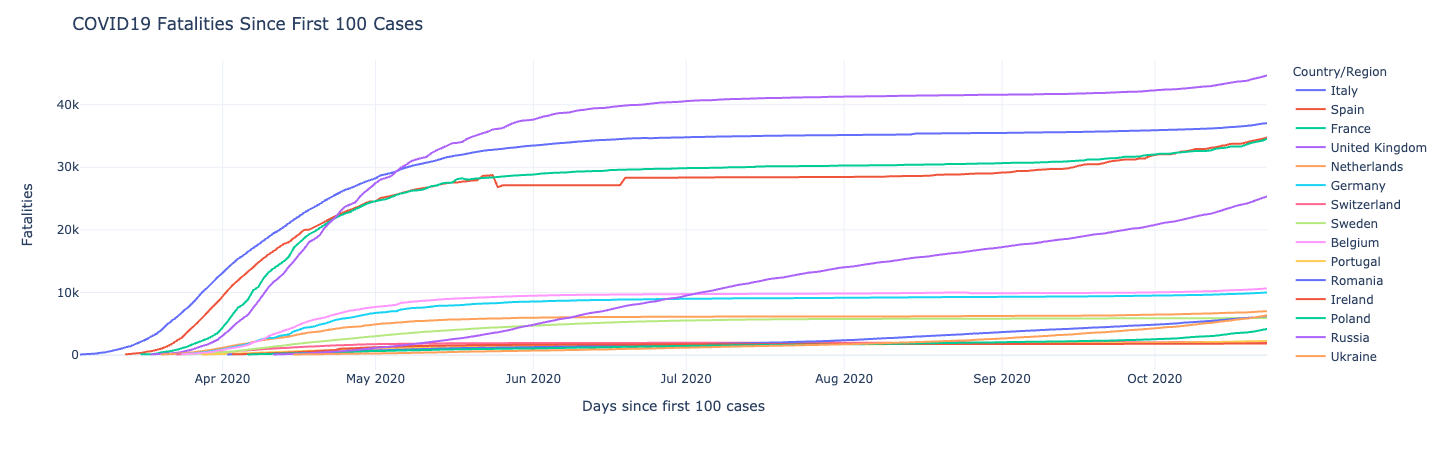

In [80]:
fig = px.line(fatalities_eu, x='Date', y='Fatalities', color='Country/Region')

fig.update_layout(title='COVID19 Fatalities Since First 100 Cases',
                  xaxis_title='Days since first 100 cases',
                  yaxis_title='Fatalities'
                 )
fig.show()